# Sub-optimal Discontinuous Current-Clamp switching rates lead to deceptive mouse neu- ronal firing
Marin Manuel, PhD

Université de Paris, SPPIN - Saints-Pères Paris Institute for the Neurosciences, CNRS, Paris,
France

Contact: \<firstname\> *dot* \<lastname\> *at* neurobio.org

This notebook and repository contains all the data needed to reproduce the analyses of the paper

## Imports and initialization...

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
from io import StringIO
from IPython.display import display, Markdown as md, Image
import brian2 as br

'2.4.1'

In [2]:
# from https://matplotlib.org/3.1.1/gallery/misc/anchored_artists.html
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.offsetbox import (
    AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker, HPacker)

class HSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, frameon=True, textprops=None, **kwargs):
        """
        Draw a horizontal bar with the size in data coordinate of the given
        axes. A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), size, 0, ec="black", lw=plt.rcParams['axes.linewidth']))

        self.txt_label = TextArea(label, minimumdescent=False, textprops=textprops)

        self._box = VPacker(children=[self.size_bar, self.txt_label],
                            align="center",
                            pad=0, sep=sep)

        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon, **kwargs)
        

class VSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, frameon=True, textprops=None, **kwargs):
        """
        Draw a horizontal bar with the size in data coordinate of the given
        axes. A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), 0, size, ec="black", lw=plt.rcParams['axes.linewidth']))
        
        textprops = textprops or {}
        if 'rotation' not in textprops:
            textprops['rotation'] = 90

        self.txt_label = TextArea(label, minimumdescent=False, textprops=textprops)

        self._box = HPacker(children=[self.txt_label, self.size_bar],
                            align="center",
                            pad=0, sep=sep)

        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon, **kwargs)

# Figures

In [3]:
VmColor = 'xkcd:emerald'
ImColor = 'xkcd:royal blue'
IdccColor = 'xkcd:cerulean blue'
FreqColor = 'k'
monitorColor = 'xkcd:reddish'

### Figure-case-study

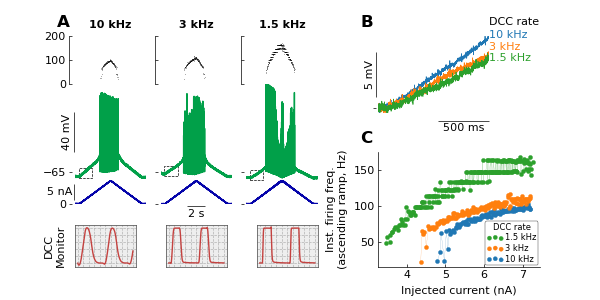

In [4]:
plt.style.use(['default','MM-paper'])


fig = plt.figure(figsize=(6,3), dpi=100)
gs0 = matplotlib.gridspec.GridSpec(1,2, figure=fig, wspace=0.3, width_ratios=[1.5,1])
gs10 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0], height_ratios=[2,0.5])

gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec=gs10[0],
                                                   height_ratios=[0.5,1,0.25],
                                                   hspace=0)
gs01 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs0[1],
                                                   width_ratios=[3,1],
                                                   height_ratios=[1,1.5],
                                                   hspace=0.4)
gs11 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs10[1], wspace=0.5)


axFreq1 = fig.add_subplot(gs00[0,0])
axFreq2 = fig.add_subplot(gs00[0,1], sharey=axFreq1)
axFreq3 = fig.add_subplot(gs00[0,2], sharey=axFreq1)
axVm1 = fig.add_subplot(gs00[1,0], sharey=None, sharex=axFreq1)
axVm2 = fig.add_subplot(gs00[1,1], sharey=axVm1, sharex=axFreq2)
axVm3 = fig.add_subplot(gs00[1,2], sharey=axVm1, sharex=axFreq3)
axIm1 = fig.add_subplot(gs00[2,0], sharey=None, sharex=axFreq1)
axIm2 = fig.add_subplot(gs00[2,1], sharey=axIm1, sharex=axFreq2)
axIm3 = fig.add_subplot(gs00[2,2], sharey=axIm1, sharex=axFreq3)
axSl = fig.add_subplot(gs01[0,:-1])

with plt.style.context(['default','MM-paper',
                        {'axes.autolimit_mode': 'data','axes.xmargin':0.05, 'axes.ymargin':0.05}]):
    axIF = fig.add_subplot(gs01[1,:])

with plt.style.context('MM-model'):
    axMon1 = fig.add_subplot(gs11[0], sharey=None)
    axMon2 = fig.add_subplot(gs11[1], sharey=axMon1)
    axMon3 = fig.add_subplot(gs11[2], sharey=axMon2)


for file,freq,(axVm,axIm) in zip(['20200707_Cell4099_001_DCCfreq_DCC10kHz_traces.txt',
                                  '20200707_Cell4099_001_DCCfreq_DCC3kHz_traces.txt',
                                  '20200707_Cell4099_001_DCCfreq_DCC1.5kHz_traces.txt'],
                                 [10,3,1.5],
                                [[axVm1,axIm1],[axVm2,axIm2],[axVm3,axIm3]]):
    df = pd.read_csv(file,sep='\t',header=0)
    axVm.plot(df['Time'],df['9 10Vm+hr'], '-', lw=1, c=VmColor)
    axIm.plot(df['Time'],df['4 Im'], '-', lw=1, c=ImColor)
    
    axVm.set_yticks([-65])
    axIm.set_yticks([0])
    axIm.set_xticks([])
    axIm.set_facecolor((0,0,0,0))  # background color hides some elements from axes above. This sets it transparent
    
    r = matplotlib.patches.Rectangle(xy=(df['Time'][0]+0.4,df['9 10Vm+hr'][0]-2.5), width=1.5, height=10,
                                lw=0.5, ls='--', ec='k', fc='none', clip_on=False)
    axVm.add_patch(r)

    
    for ax in [axVm,axIm]:
        sns.despine(ax=ax, left=False, bottom=True, offset=4)
        ax.spines['left'].set_visible(False)
        if not ax.is_first_col():
            plt.setp(ax.get_yticklabels(), visible=False)

ax = axVm1
v = VSizeBar(ax.transData, 40, '40 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(v)
ax = axIm1
i = VSizeBar(ax.transData, 5, '5 nA', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8, rotation=0))
ax.add_artist(i)
ax = axIm2
t = HSizeBar(ax.transData, 2, '2 s', loc='upper center',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(0.5, -0.1),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(t)
    
for file,freq,axFreq in zip(['20200707_Cell4099_001_DCCfreq_DCC10kHz_spikes.txt',
                             '20200707_Cell4099_001_DCCfreq_DCC3kHz_spikes.txt',
                             '20200707_Cell4099_001_DCCfreq_DCC1.5kHz_spikes.txt'],
                            ['10 kHz', '3 kHz', '1.5 kHz'],
                            [axFreq1,axFreq2,axFreq3]):
    times = np.loadtxt(file, skiprows=16)
    freqs = 1/np.diff(times)
    axFreq.plot(times[1:],freqs,'o',c=FreqColor,ms=0.1)
    axFreq.set_title(freq, fontsize=8)
    sns.despine(ax=axFreq, left=False, bottom=True, offset=4)
    if not axFreq.is_first_col():
        plt.setp(axFreq.get_yticklabels(), visible=False)

axFreq1.set_ylim(0,200)


for file,freq in zip(['20200707_Cell4099_001_DCCfreq_IFCurve_DCC10kHz.txt',
                      '20200707_Cell4099_001_DCCfreq_IFCurve_DCC3kHz.txt',
                      '20200707_Cell4099_001_DCCfreq_IFCurve_DCC1.5kHz.txt'],
                     ['10 kHz', '3 kHz', '1.5 kHz']):
    df = pd.read_csv(file, sep='\t', header=0)
    axIF.scatter(df.iloc[:,2], df.iloc[:,3], marker='o', s=3**2, label=freq, clip_on=False)
    axIF.plot(df.iloc[:,2], df.iloc[:,3], '-', lw=0.1, clip_on=False)

axIF.set_xlabel('Injected current (nA)')
axIF.set_ylabel('Inst. firing freq.\n(ascending ramp, Hz)')
h,l = axIF.get_legend_handles_labels()
axIF.legend(h[::-1],l[::-1], loc='lower right', 
            title='DCC rate', title_fontsize=plt.rcParams['legend.fontsize'],
            borderpad=0.2, labelspacing=0.2, handletextpad=0.2, borderaxespad=0.2, scatterpoints=3)
axIF.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5))

for file,freq,pos in zip(['20200707_Cell4099_001_DCCfreq_DCC10kHz_traces.txt',
                          '20200707_Cell4099_001_DCCfreq_DCC3kHz_traces.txt',
                          '20200707_Cell4099_001_DCCfreq_DCC1.5kHz_traces.txt'],
                         ['10 kHz', '3 kHz', '1.5 kHz'],
                         [8.  , 6.75, 5.5 ]):
    df = pd.read_csv(file,sep='\t',header=0)
    df['Time'] -= df.loc[0,'Time']
    df['9 10Vm+hr'] -= df.loc[df['Time']<0.5,'9 10Vm+hr'].mean()
    df['smVm'] = df['9 10Vm+hr'].rolling(window=20, center=True).mean()
    l, = axSl.plot(df.loc[(df['Time']>0.4)&(df['Time']<1.5),'Time'],df.loc[(df['Time']>0.4)&(df['Time']<1.5),'smVm'], label=freq)
    axSl.annotate(freq, xy=(1, pos), xycoords=('axes fraction', 'data'),
                                     xytext=(0,0), textcoords='offset points',
                                     ha='left', va='center', fontsize=8, color=l.get_color())
axSl.annotate('DCC rate', xy=(1, 9.5), xycoords=('axes fraction', 'data'),
                                     xytext=(0,0), textcoords='offset points',
                                     ha='left', va='center', fontsize=8, color='k')
sns.despine(ax=axSl, bottom=True, offset=4)
axSl.spines['left'].set_visible(False)
axSl.set_yticks([0])
axSl.set_xticks([])
axSl.set_yticklabels([])

v = VSizeBar(axSl.transData, 5, '5 mV', loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=axSl.transAxes,textprops=dict(fontsize=8))
axSl.add_artist(v)

t = HSizeBar(axSl.transData, 0.500, '500 ms', loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=axSl.transAxes,textprops=dict(fontsize=8))
axSl.add_artist(t)

for file,ax in zip(
    ['./20200707_Cell4099_001_DCCfreq_DCC10kHz_monitor.txt',
     './20200707_Cell4099_001_DCCfreq_DCC3kHz_monitor.txt',
     './20200707_Cell4099_001_DCCfreq_DCC1.5kHz_monitor.txt'],
    [axMon1, axMon2, axMon3]):
    df = pd.read_csv(file, sep='\t', header=0)
    df = df.set_index(pd.to_datetime(df['Time'], unit='s'))
    df = df.resample('1us').interpolate('quadratic', order=3)
    ax.plot(df['Time'], df['3 Monitor'], '-', lw=1, c=monitorColor)
    xmin, xmax = df['Time'].min(), df['Time'].max()
    ax.set_xticks(np.linspace(xmin,xmax,11))
    
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5, min_n_ticks=5))
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    #ax.plot([0.5],[-0.01], 'k^', ms=4, transform=ax.transAxes, clip_on=False, zorder=10)

axMon1.set_ylabel('DCC\nMonitor', fontsize=plt.rcParams['axes.labelsize'])


for ax,l in zip([axFreq1, axSl, axIF],'ABC'):
    ax.annotate(l, xy=(0,1), xycoords='axes fraction',
                 xytext=(-4,4), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12, fontweight='bold')

fig.savefig('../Figure-case-study.png', dpi=300)

### Figure-f-i-curves

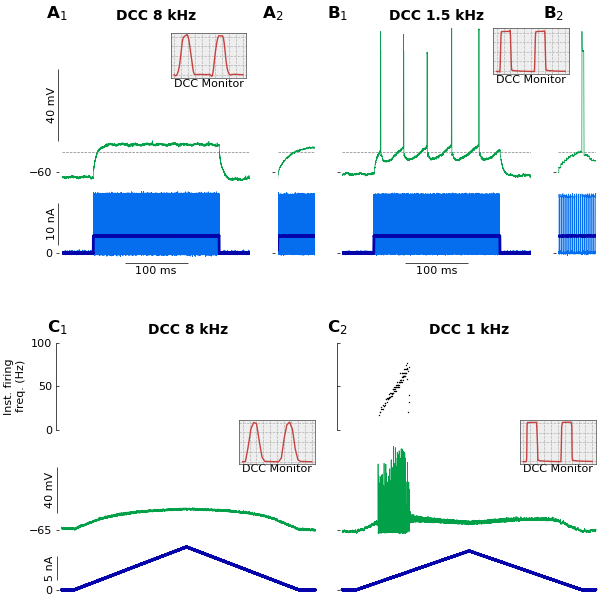

In [5]:
df1 = pd.read_csv('./20200701_Cell4091_007_DCCfreq_1.5kHz.txt', sep='\t', header=0, index_col=None)
df2 = pd.read_csv('./20200701_Cell4091_007_DCCfreq_8kHz.txt', sep='\t', header=0, index_col=None)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use(['default','MM-paper'])
fig = plt.figure(figsize=(6,6), constrained_layout=True)

gs1 = matplotlib.gridspec.GridSpec(6,4, 
                                   height_ratios=[1.75,0.75,0.25,1,1,0.5], 
                                   width_ratios=[1,0.2,1,0.2], figure=fig)

axVms = np.empty(shape=(4,), dtype=np.object)
axIms = np.empty(shape=(4,), dtype=np.object)
for i in range(4):
    axVms[i] = fig.add_subplot(gs1[0,i], sharex=axVms[i], sharey=axVms[0])
    axIms[i] = fig.add_subplot(gs1[1,i], sharex=axVms[i], sharey=axIms[0])

axVms[2].plot(df1['Time'],df1['1 10Vm'], c=VmColor)
axIms[2].plot(df1['Time'],df1['5 I1 cont'], c=IdccColor)
axIms[2].plot(df1['Time'],df1['4 Im'].rolling(50, center=True).mean(), c=ImColor, lw=2)
axVms[2].set_title('DCC 1.5 kHz')

axVms[3].plot(df1['Time'],df1['1 10Vm'], c=VmColor)
axIms[3].plot(df1['Time'],df1['5 I1 cont'], c=IdccColor)
axIms[3].plot(df1['Time'],df1['4 Im'].rolling(50, center=True).mean(), c=ImColor, lw=2)
xmin = 19.005
w = 0.015
axVms[3].set_xlim(xmin,xmin+w)


axVms[0].plot(df2['Time'],df2['1 10Vm'], c=VmColor)
axIms[0].plot(df2['Time'],df2['5 I1 cont'], c=IdccColor)
axIms[0].plot(df2['Time'],df2['4 Im'].rolling(50, center=True).mean(), c=ImColor, lw=2)
axVms[0].set_title('DCC 8 kHz')

axVms[1].plot(df2['Time'],df2['1 10Vm'], c=VmColor)
axIms[1].plot(df2['Time'],df2['5 I1 cont'], c=IdccColor)
axIms[1].plot(df2['Time'],df2['4 Im'].rolling(50, center=True).mean(), c=ImColor, lw=2)
xmin = 109.804
axVms[1].set_xlim(xmin, xmin+w)

for ax in axVms[:]:
    ax.axhline(-48.4, ls='--', lw=0.5, color='grey', zorder=-1)

for ax in axVms.flat:
    sns.despine(ax=ax, offset=4, bottom=True)
    ax.set_xticks([])
for ax in axIms.flat:
    sns.despine(ax=ax, offset=4, bottom=True)
    ax.set_xticks([])
for ax in axVms[:]:
    ax.set_yticks([-60])
    ax.spines['left'].set_visible(False)
    if not ax.is_first_col():
        plt.setp(ax.get_yticklabels(), visible=False)
for ax in axIms[:]:
    ax.set_yticks([0])
    ax.spines['left'].set_visible(False)
    if not ax.is_first_col():
        plt.setp(ax.get_yticklabels(), visible=False)

ax = axVms[0]
v = VSizeBar(ax.transData, 40, '40 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8))
ax.add_artist(v)

ax = axIms[0]
i = VSizeBar(ax.transData, 10, '10 nA', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8))
ax.add_artist(i)

for ax in axIms[::2]:
    t = HSizeBar(ax.transData, 0.1, '100 ms', loc='upper center',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(0.5, -0.1),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
    ax.add_artist(t)
    
with plt.style.context('MM-model'):
    axMon1 = inset_axes(axVms[0], width='40%', height='30%')
    axMon2 = inset_axes(axVms[2], width="100%", height="100%",
                   bbox_to_anchor=(.8, .7, .4, .3),
                   bbox_transform=axVms[2].transAxes, loc=2, borderpad=0)
    
for file,ax in zip(['./20200701_Cell4091_007_DCCfreq_8kHz_monitor.txt',
                    './20200701_Cell4091_007_DCCfreq_1.5kHz_monitor.txt'],
                   [axMon1, axMon2]):
    df = pd.read_csv(file, sep='\t', header=0)
    df = df.set_index(pd.to_datetime(df['Time'], unit='s'))
    df = df.resample('1us').interpolate('quadratic', order=3)
    ax.plot(df['Time'], df['3 Monitor'], '-', lw=1, c=monitorColor)
    xmin, xmax = df['Time'].min(), df['Time'].max()
    ax.set_xticks(np.linspace(xmin,xmax,11))
    
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5, min_n_ticks=5))
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    #ax.plot([0.5],[-0.01], 'k^', ms=4, transform=ax.transAxes, clip_on=False, zorder=10)
    ax.set_xlabel('DCC Monitor', fontsize=plt.rcParams['axes.labelsize'], labelpad=-2)

for l,ax in zip(['A$_1$','A$_2$', 'B$_1$', 'B$_2$'],
                axVms[:]):
    ax.annotate(l, xy=(0,1), xycoords='axes fraction',
                 xytext=(4,4), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12, fontweight='bold')
    
    
axs = np.empty(shape=(3,2), dtype=np.object)
for i in range(3):
    for j,k in enumerate([0,2]):
        #print(i,j,k)
        axs[i,j] = fig.add_subplot(gs1[i+3,k:k+2], sharex=axs[0,j], sharey=axs[i,0])

for j,file in enumerate(['20200624_Cell4083_003_DCC8kHz_traces.txt',
                         '20200624_Cell4083_003_DCC1kHz_traces.txt']):
    df = pd.read_csv(file, sep='\t', header=0)
    axs[1,j].plot(df['Time'], df['9 Vm+hr'], '-', c=VmColor, clip_on=False)
    axs[2,j].plot(df['Time'], df['2 Im'], '-', c=ImColor, lw=2, clip_on=False)

file = '20200624_Cell4083_003_DCC1kHz_spikes.txt'
axFreq = axs[0,1]
times = np.loadtxt(file, skiprows=16)
freqs = 1/np.diff(times)
axFreq.plot(times[1:],freqs,'o',c=FreqColor,ms=0.5)
axFreq.set_ylim(0,100)

for ax in axs.flat:
    sns.despine(ax=ax, left=False, bottom=True, offset=4)
    if not ax.is_first_col():
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([])
axs[1,0].set_yticks([-65])
axs[2,0].set_yticks([0])
for ax in axs[1:,:].flat:
    ax.spines['left'].set_visible(False)
axs[0,0].set_ylabel('Inst. firing\nfreq. (Hz)')

ax = axs[1,0]
v = VSizeBar(ax.transData, 40, '40 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8))
ax.add_artist(v)

ax = axs[2,0]
i = VSizeBar(ax.transData, 5, '5 nA', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8))
ax.add_artist(i)


with plt.style.context('MM-model'):
    ax = axs[1,0]
    axMon1 = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.7, .8, .3, .5),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
    ax = axs[1,1]
    axMon2 = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.7, .8, .3, .5),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
    
for file,ax in zip(['./20200624_Cell4083_003_DCC8kHz_monitor.txt',
                    './20200624_Cell4083_003_DCC1kHz_monitor.txt'],
                   [axMon1, axMon2]):
    df = pd.read_csv(file, sep='\t', header=0)
    df.drop_duplicates(subset=['Time'], inplace=True)
    df = df.set_index(pd.to_datetime(df['Time'], unit='s'))
    df.resample('1us').interpolate('quadratic')

    ax.plot(df['Time'], df['3 Monitor'], '-', lw=1, c=monitorColor)
    xmin, xmax = df['Time'].min(), df['Time'].max()
    ax.set_xticks(np.linspace(xmin,xmax,11))
    
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5, min_n_ticks=5))
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    #ax.plot([0.5],[-0.01], 'k^', ms=4, transform=ax.transAxes, clip_on=False, zorder=10)
    ax.set_xlabel('DCC Monitor', fontsize=plt.rcParams['axes.labelsize'], labelpad=-2)

for ax,t,l in zip(axs[0,:],
                  ['DCC 8 kHz', 'DCC 1 kHz'],
                  ['C$_1$','C$_2$']):
    ax.set_title(t)
    ax.annotate(l, xy=(0,1), xycoords='axes fraction',
                 xytext=(4,4), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12, fontweight='bold')

fig.savefig('../Figure-f-i-curves.png', dpi=300)

### Figure-f-i-curves2

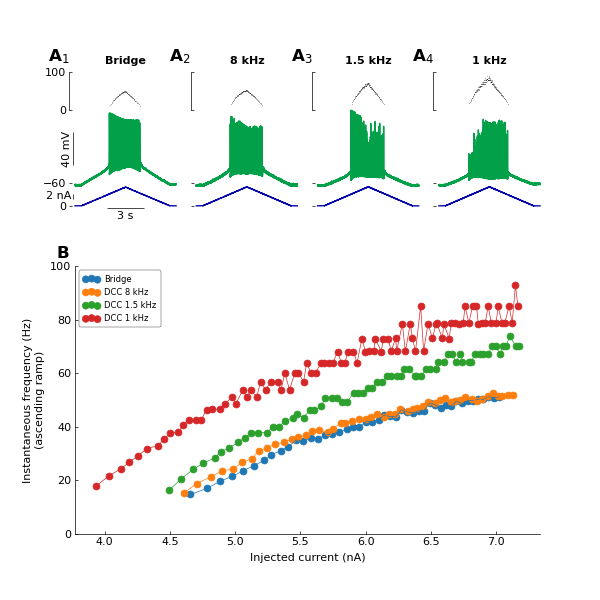

In [6]:
plt.style.use(['default','MM-paper'])


fig = plt.figure(figsize=(6,2+4), dpi=100)
gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig, hspace=0.3, height_ratios=[2,4])
gs00 = matplotlib.gridspec.GridSpecFromSubplotSpec(3,4, subplot_spec=gs0[0],
                                                   height_ratios=[0.5,1,0.25],
                                                   hspace=0)
gs01 = matplotlib.gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs0[1],)

axs = np.empty(shape=(3,4), dtype=np.object)

for j in range(3):
    for i in range(4):
        axs[j,i] = fig.add_subplot(gs00[j,i], sharey=axs[j,0], sharex=axs[0,i])

with plt.style.context(['default',
                        'MM-paper',
                        {'axes.autolimit_mode': 'data','axes.xmargin':0.05, 'axes.ymargin':0.05}]):
    axIF = fig.add_subplot(gs01[0])
    

for file, freq, (axVm,axIm) in zip(['20200701_Cell4091_008_CCRamp_Bridge_traces.txt',
                            '20200701_Cell4091_008_CCRamp_8kHz_traces.txt',
                            '20200701_Cell4091_008_CCRamp_1.5kHz_traces.txt',
                            '20200701_Cell4091_008_CCRamp_1.0kHz_traces.txt'],
                            ['Bridge','8 kHz', '1.5 kHz', '1 kHz'],
                           zip(axs[1,:], axs[2,:])):
    df = pd.read_csv(file,sep='\t',header=0)
    axVm.plot(df['Time'],df['1 10Vm'], '-', lw=1, c=VmColor, clip_on=False)
    axIm.plot(df['Time'],df['4 Im'], '-', lw=1, c=ImColor, clip_on=False)
    
for file, freq, axFreq in zip(['20200701_Cell4091_008_CCRamp_Bridge_traces_spikes.txt',
                            '20200701_Cell4091_008_CCRamp_8kHz_traces_spikes.txt',
                            '20200701_Cell4091_008_CCRamp_1.5kHz_traces_spikes.txt',
                            '20200701_Cell4091_008_CCRamp_1.0kHz_traces_spikes.txt'],
                            ['Bridge','8 kHz', '1.5 kHz', '1 kHz'],
                            axs[0,:]):
    times = np.loadtxt(file, skiprows=16)
    freqs = 1/np.diff(times)
    axFreq.plot(times[1:],freqs,'o',c=FreqColor,ms=0.1)
    axFreq.set_title(freq, fontsize=8)
    sns.despine(ax=axFreq, left=False, bottom=True, offset=4)
    if not axFreq.is_first_col():
        plt.setp(axFreq.get_yticklabels(), visible=False)
axs[0,0].set_ylim(0,100)

for ax in axs[1,:]:
    sns.despine(ax=ax, offset=4, bottom=True)
    ax.set_yticks([-60])
    if not ax.is_first_col():
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.spines['left'].set_visible(False)
for ax in axs[2,:]:
    sns.despine(ax=ax, offset=4, bottom=True)
    ax.set_yticks([0])
    ax.set_xticks([])
    if not ax.is_first_col():
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.spines['left'].set_visible(False)

    
ax = axs[1,0]
v = VSizeBar(ax.transData, 40, '40 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8))
ax.add_artist(v)

ax = axs[2,0]
i = VSizeBar(ax.transData, 2, '2 nA', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes, textprops=dict(fontsize=8, rotation=0))
ax.add_artist(i)

t = HSizeBar(ax.transData, 3, '3 s', loc='upper center',
             pad=0, borderpad=0, sep=2,
             frameon=False,
             bbox_to_anchor=(0.5, -0.1),
             bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(t)

for i,(file,freq) in enumerate(zip(['20200701_Cell4091_008_DCCfreq_IFCurve_Bridge-2.txt',
                                    '20200701_Cell4091_008_DCCfreq_IFCurve_DCC8kHz.txt',
                                    '20200701_Cell4091_008_DCCfreq_IFCurve_DCC1.5kHz.txt',
                                    '20200701_Cell4091_008_DCCfreq_IFCurve_DCC1kHz.txt'],
                                   ['Bridge','DCC 8 kHz','DCC 1.5 kHz','DCC 1 kHz'])):
    df = pd.read_csv(file, sep='\t', header=0)
    axIF.scatter(df.iloc[:,2], df.iloc[:,3], marker='o', lw=0.5, label=freq, clip_on=False)
    axIF.plot(df.iloc[:,2], df.iloc[:,3], '-', lw=0.5, clip_on=False)

axIF.set_xlabel('Injected current (nA)')
axIF.set_ylabel('Instantaneous frequency (Hz)\n(ascending ramp)')
axIF.legend(loc='upper left', scatterpoints=3)
axIF.set_ylim(0,100)

for l,ax in zip([f'A$_{i+1}$' for i in range(4)], axs[0,:]):
     ax.annotate(l, xy=(0,1), xycoords='axes fraction',
                 xytext=(-4,4), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12, fontweight='bold')

axIF.annotate('B', xy=(0,1), xycoords='axes fraction',
                 xytext=(-4,4), textcoords='offset points',
                 ha='right', va='bottom', fontsize=12, fontweight='bold')

fig.savefig('../Figure-f-i-curves2.png', dpi=300)

### Figure-summary-stats

In [440]:
summary = pd.read_csv('./Cell_summary.csv')

In [441]:
summary

,cell,DCCfreq,relDCCfreq,Ion,Ioff,ascSlope,Vthr,deltaI,deltaF,descSlope,globalSlope,file,tauM,expDate,mouseType,mouseSex,mouseAge,mouseWeight,electrodeType,electrodeR
0,Cell4084,8000,26.24,12.315,14.206,12.312,-60.298,1.892,19.587,19.857,10.683,7,3.28,2020-06-24,C57BL/6,M,169,28,KCl 3M,16
1,Cell4084,3000,9.84,12.468,14.020,12.544,-62.810,1.552,16.937,21.744,11.909,7,3.28,2020-06-24,C57BL/6,M,169,28,KCl 3M,16
2,Cell4084,1000,3.28,9.969,11.596,16.362,-70.024,1.627,-1.000,14.460,8.117,7,3.28,2020-06-24,C57BL/6,M,169,28,KCl 3M,16
3,Cell4090,1000,5.12,3.165,4.066,34.262,-53.363,0.901,4.938,NaN,NaN,6,5.12,2020-07-01,C57BL/6,M,176,31,KCl 3M,17
4,Cell4090,3000,15.36,3.830,4.778,9.476,-47.018,0.948,-3.191,NaN,NaN,6,5.12,2020-07-01,C57BL/6,M,176,31,KCl 3M,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Cell4130,3000,10.26,6.235,7.733,19.192,-45.671,1.498,2.837,30.294,18.650,6,3.42,2020-10-08,B6SJL,M,53,25,KAcetate 2M,25
76,Cell4130,10000,34.20,6.230,7.782,16.362,-39.279,1.551,2.301,28.075,15.563,6,3.42,2020-10-08,B6SJL,M,53,25,KAcetate 2M,25
77,Cell4130,1000,3.42,4.684,6.187,56.982,-56.842,1.503,-2.786,42.796,50.983,6,3.42,2020-10-08,B6SJL,M,53,25,KAcetate 2M,25
78,Cell4130,0,0.00,5.997,8.006,15.669,NaN,2.009,14.557,23.934,13.987,6,3.42,2020-10-08,B6SJL,M,53,25,KAcetate 2M,25


In [442]:
# Normalize values to the value measured with the highest DCC freq tested
params = ['Ion', 'Ioff', 'deltaI', 'deltaF', 'ascSlope', 'descSlope','globalSlope', 'Vthr']
def norm_highest_dcc(df,params=None):
    freqs = df['DCCfreq']
    row = df.sort_values(by='DCCfreq', ascending=False).iloc[0][params]
    out = df[params]/row
    df[params] = out.astype(float)
    df['DCCfreq'] = freqs
    return df
summary_norm = summary.groupby(['cell']).apply(norm_highest_dcc, params=params)

In [443]:
# Interpolate all curves on the same "relative DCC freq"
# for averaging
from scipy import interpolate
def interpolate_relDCC(df):
    #print(df)
    x = df['relDCCfreq']
    out = pd.DataFrame(columns=df.columns)
    xx = np.arange(3, np.ceil(x.max()), 1)
    out['relDCCfreq'] = xx
    for c in params:
        y = df[c]
        f = interpolate.interp1d(x,y, fill_value='extrapolate')
        yy = f(xx)
        out[c] = np.array(yy).astype(float)
    #print(out)
    return out
        
summary_interp = summary_norm.loc[summary_norm['DCCfreq']>0].groupby('cell')[['relDCCfreq']+params].apply(interpolate_relDCC).reset_index()

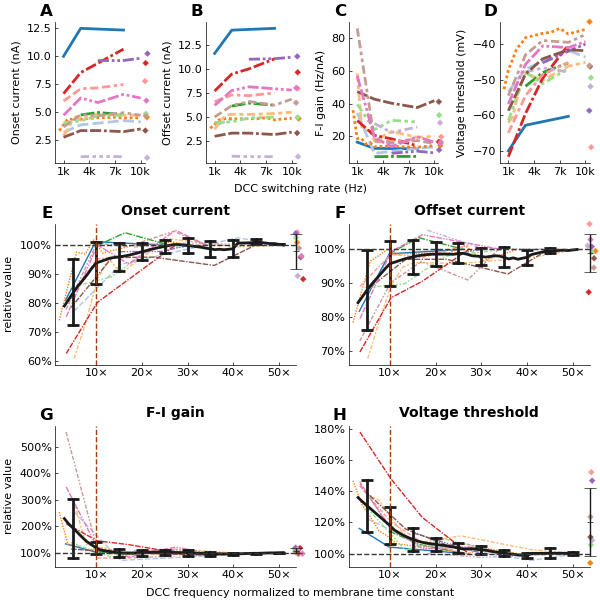

In [444]:
from collections.abc import Iterable
plt.style.use(['default','MM-paper',{'axes.xmargin':0.05, 'axes.ymargin':0.05}])

bridge_pos = 1.01
bridge_jitter = 0.01

cols = ['Ion','Ioff','ascSlope','Vthr']
labels = ['Onset current (nA)','Offset current (nA)', 'F-I gain (Hz/nA)', 'Voltage threshold (mV)']
hues = {cell:color for cell,color in zip(summary['cell'].unique(),plt.get_cmap('tab20')(range(20)))}

N = len(cols)
fig = plt.figure(figsize=(6,6), dpi=100, constrained_layout=True)

gs0 = matplotlib.gridspec.GridSpec(3, 4, height_ratios=[2,2,2], figure=fig)
axsAbs = np.empty(shape=(N,), dtype=np.object)
axsNorm = np.empty(shape=(2,2), dtype=np.object)
for i in range(N):
    axsAbs[i] = fig.add_subplot(gs0[0,i], sharex=axsAbs[0])
for i in range(2):
    for k,j in enumerate([0,2]):
        axsNorm[i,k] = fig.add_subplot(gs0[i+1,j:j+2], sharex=axsNorm[1,0])
    
for c,l,ax in zip(cols,labels,axsAbs):
    sns.lineplot(data=summary.loc[summary.DCCfreq>0], x='DCCfreq', y=c, 
                 hue='cell', palette=hues, lw=2,
                 style='cell', ci=None,
                 ax=ax, legend=False)
    ax.set_ylabel(l)
    ax.set_xlabel(' ')
    
    # Draw a diamond on the right side of the plot with the value
    # measured in Bridge mode
    n = len(summary[summary['DCCfreq']==0].groupby('cell'))
    x = np.random.normal(loc=bridge_pos,scale=bridge_jitter,size=n)
    y = summary[summary['DCCfreq']==0].groupby('cell').mean()[c]
    ax.scatter(x,y,c=[hues[c] for c in y.index], marker='D', s=9, transform=ax.get_yaxis_transform(), clip_on=False)

axsAbs[0].set_xticks([1000,4000,7000,10000])
axsAbs[0].xaxis.set_major_formatter(matplotlib.ticker.EngFormatter(unit='',sep=''))
l1 = axsAbs[0].set_xlabel(' ')

labels = ['Onset current','Offset current', 'F-I gain', 'Voltage threshold']


for c,l,ax in zip(cols,labels,axsNorm.flat):
    sns.lineplot(data=summary_norm.loc[summary_norm.DCCfreq>0], 
                 x='relDCCfreq', y=c, 
                 hue='cell', palette=hues, ci=None,
                 style='cell', #dashes=dashes,
                 ax=ax, 
                 legend=False, lw=1, sort=True, zorder=0, alpha=1)
    sns.lineplot(data=summary_interp,
                 x='relDCCfreq', y=c, ax=ax, legend=False, sort=True,
                 lw=2, color='k', ci='sd',
                 err_style='bars', 
                 err_kws={'capsize':4, 'elinewidth':2, 'capthick':2, 'errorevery':(2,5)})
    # Draw a diamond on the right side of the plot with the value
    # measured in Bridge mode as well as error bars with mean ± SD
    n = len(summary_norm[summary_norm['DCCfreq']==0].groupby('cell'))
    x = np.random.normal(loc=bridge_pos,scale=bridge_jitter,size=n)
    y = summary_norm[summary_norm['DCCfreq']==0].groupby('cell').mean()[c]
    ax.scatter(x,y,c=[hues[c] for c in y.index], marker='D', s=9, transform=ax.get_yaxis_transform(), clip_on=False)
    out = ax.errorbar(x=1,y=y.mean(),yerr=y.std(), transform=ax.get_yaxis_transform(), clip_on=False,
                fmt="_", capsize=4, lw=1, color='k', elinewidth=1)
    # artists in the bridge errorbars are clipped if outside the plot, this
    # sets clip_on = False on all the artists
    for a in out:
        a = [a] if not isinstance(a, Iterable) else a
        for b in a:
            b.set_clip_on(False)

    ax.axhline(1, ls='--', c='xkcd:dark grey', lw=1)
    ax.axvline(10, ls='--', c='xkcd:rust', lw=1)
    ax.set_title(l)
    ax.set_ylabel('')
    ax.set_xlabel(' ')
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1, decimals=0))
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, decimals=0, symbol='×'))
    ax.set_xlim(left=1)
    if ax.is_first_col():
        ax.set_ylabel('relative value')

l2 = axsNorm[1,0].set_xlabel(' ')

for l,ax in zip('ABCDEFGHIJKL',np.concatenate([axsAbs.flatten(),axsNorm.flatten()])):
    ax.annotate(l, xy=(0,1), xycoords='axes fraction',
                   xytext=(-2,2), textcoords='offset points',
                   ha='right', va='bottom', fontsize=12, fontweight='bold')

# Hack to get a x-label at the same place as a normal x-label would be,
# but centered in the figure
fig.canvas.draw()
bbox = l1.get_window_extent()
_,y = fig.transFigure.inverted().transform([bbox.x0,bbox.y0])
fig.text(0.5, y, 'DCC switching rate (Hz)', 
         ha='center', fontsize=plt.rcParams['axes.labelsize'], fontweight=plt.rcParams['axes.labelweight'])    

bbox = l2.get_window_extent()
_,y = fig.transFigure.inverted().transform([bbox.x0,bbox.y0])
fig.text(0.5, y, 'DCC frequency normalized to membrane time constant', 
         ha='center', fontsize=plt.rcParams['axes.labelsize'], fontweight=plt.rcParams['axes.labelweight'])    

fig.savefig('../Figure-summary-stats.png', dpi=300)

## Numerical simulations

Numerical simulations are performed using the `Brian` simulator (v. 2.4).

In [13]:
import brian2 as br
from brian2.units import *
from tqdm.notebook import tqdm
from tqdm.contrib.itertools import product as tqdm_product

In [14]:
def chop_current(current, dt, freq=1*kHz, duty_cycle=1/3):
    # pad the current array to have a whole number of switching periods
    N_dcc = int(1 / freq / dt)  # number of point in a DCC period
    N = int(np.ceil(current.size / N_dcc))  # number of DCC periods (rounded up)
    # copy, scale, and pad `current` in `chopped current`
    chopped_current = np.zeros(N * N_dcc)
    chopped_current[:current.size] = current / duty_cycle
    # this bit of code reshape the array so that all the DCC periods are aligned
    chopped_current = chopped_current.reshape((N, N_dcc))
    # then replaces the second part of the `duty_cycle` by zeros
    chopped_current[:, int(duty_cycle / freq / dt):] = 0
    # finally re-linearize the array and trim to the initial length
    chopped_current = chopped_current.ravel()[:current.size]
    return chopped_current

In [15]:
def create_ramp(dt, ramp_rate, ramp_max, downward=True):
    # current waveform
    N = int(ramp_max/ramp_rate/dt)
    N *= 2 if downward else 1
    I_ramp = np.full(shape=N,fill_value=ramp_rate*dt)
    if downward:
        I_ramp[int(N/2):] *= -1
    I_ramp = np.cumsum(I_ramp)
    return I_ramp

In [16]:
class brian_tqdm(tqdm):
    """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""
    def update_to(self, time, current_progress, start, end):
        """
        time  : float [seconds]
            amount of time elapsed (in seconds)
        current_progress  : float
            fraction complete from 0 to 1
        start : float [seconds]
            the start time of the simulation
        end : float [seconds]
            the duration of the simulation
        """
        return self.update(current_progress - self.n)

### Electrode + Cell

Both the cell and the electrodes are modeled as passive RC circuits with equations:

$
C * \frac{dV}{dt} = G * (V_0-V) + I_{inj}
$
where
$
C = G * \tau
$

For the cell, the parameters where chosen as $G = G_{in} = 0.2 \mu S$, $\tau_M = 5 ms$

For the electrode, the same equation is used, but $G = 1 \mu S$ and $\tau_e = \tau_M / 200$

If the Bridge were perfectly balanced, the amplifier would record the true voltage of the cell ($V_{bridge} = V_m$).
In DCC mode, the continuous output of the amplifier ($V_{cont.}$) is the sum of $V_{cell}$ and $V_e$, where $V_{cell}$ is the response of the cell to the short pulses of current injected during the DCC. The output of the amplifier ($V_m$) is the output of a sample-and-hold circuit that measures the value of $V_{cont.}$ at the end of the DCC cycle and holds it constant until the next measure.

In [418]:
eqs = '''
dvm/dt = (G_in*(V_r-vm)+I)/(G_in*tau_M) : volt
dve/dt = (G_e*(-ve)+I)/(G_e*tau_e) : volt
I = I_com(t) : amp
'''

In [419]:
br.start_scope()

tau_M = 5*ms
R_in = 5*Mohm
G_in = 1/R_in
V_r = 0*mV
I_inj = 1

G_e = 1*uS
tau_e = tau_M/200

# DCC
DCC_freqs = [0, 1, 5, 15]*kHz
DCC_names = ['Bridge', '1 kHz', '5 kHz', '15 kHz']
D = 1/3

points_per_DCC_period = 10
dt = D / max(DCC_freqs) / points_per_DCC_period
sim_dur = 100 * ms

I_bridge = np.full(int(sim_dur/dt), fill_value=I_inj)

br.defaultclock.dt = dt
G = br.NeuronGroup(1, eqs, method='exact')
M = br.StateMonitor(G, variables=['vm','ve'], record=0)
br.store()

In [420]:
out = {}
for DCC_freq,DCC_name in zip(tqdm(DCC_freqs),DCC_names):
    br.restore()
    if DCC_freq>0:
        I_dcc = chop_current(I_bridge, dt=dt, freq=DCC_freq, duty_cycle=D)
        I_com = br.TimedArray(I_dcc*nA, dt=dt)
    else:
        I_com = br.TimedArray(I_bridge*nA, dt=dt)
    with brian_tqdm(total=1., leave=False) as pbar:
        br.run(sim_dur, report=pbar.update_to, report_period=1*second)
        df = pd.DataFrame({'I':I_com.values/nA, 
                           'Vm':M.vm[0]/mV,
                           'Ve':M.ve[0]/mV},
                          index=M.t/ms)
        out[DCC_name] = df
result_elect_cell = pd.concat(out, axis=1)

In [421]:
result_elect_cell

Bridge                     1 kHz                         5 kHz  \
               I        Vm        Ve     I        Vm            Ve     I   
0.000000     1.0  0.000000  0.000000   3.0  0.000000  0.000000e+00   3.0   
0.002222     1.0  0.002222  0.085053   3.0  0.006665  2.551583e-01   3.0   
0.004444     1.0  0.004442  0.162872   3.0  0.013327  4.886147e-01   3.0   
0.006667     1.0  0.006662  0.234072   3.0  0.019987  7.022150e-01   3.0   
0.008889     1.0  0.008881  0.299216   3.0  0.026643  8.976480e-01   3.0   
...          ...       ...       ...   ...       ...           ...   ...   
99.988889    1.0  5.000000  1.000000   0.0  4.681004  1.227310e-11   0.0   
99.991111    1.0  5.000000  1.000000   0.0  4.678924  1.122924e-11   0.0   
99.993333    1.0  5.000000  1.000000   0.0  4.676845  1.027416e-11   0.0   
99.995556    1.0  5.000000  1.000000   0.0  4.674766  9.400312e-12   0.0   
99.997778    1.0  5.000000  1.000000   0.0  4.672689  8.600790e-12   0.0   

                              15 kHz                      
                 Vm        Ve      I        Vm        Ve  
0.000000   0.000000  0.000000    3.0  0.000000  0.000000  
0.002222   0.006665  0.255158    3.0  0.006665  0.255158  
0.004444   0.013327  0.488615    3.0  0.013327  0.488615  
0.006667   0.019987  0.702215    3.0  0.019987  0.702215  
0.008889   0.026643  0.897648    3.0  0.026643  0.897648  
...             ...       ...    ...       ...       ...  
99.988889  4.778579  0.019105    0.0  4.988868  0.500461  
99.991111  4.776456  0.017480    0.0  4.986652  0.457896  
99.993333  4.774334  0.015993    0.0  4.984436  0.418950  
99.995556  4.772212  0.014633    0.0  4.982221  0.383317  
99.997778  4.770092  0.013388    0.0  4.980007  0.350715  

[45000 rows x 12 columns]

### Amplitude of the ripples

In [372]:
br.start_scope()

# Neuron parameters
tau_Ms = [2,3,4,5] * ms
R_ins = [1.5,2.5,5] * Mohm
G_ins = 1 / R_ins
I_injs = [1,5,10]
V_r = 0 * mV
I_com = 1 * nA
V_thresh = 20 * mV

# DCC parameters
DCC_freqs = np.arange(1,16,1) * kHz
D = 1 / 3

# simulation parameters
points_per_DCC_period = 10
dt = D / max(DCC_freqs) / points_per_DCC_period
sim_dur = 50 * ms

meas_window = 10*ms

br.defaultclock.dt = dt
G = br.NeuronGroup(1, eqs, method='exact')
M = br.StateMonitor(G, ['vm'], record=[0])
br.store()

In [373]:
out = []
for DCC_freq, G_in, tau_M, I_inj in tqdm_product(DCC_freqs, G_ins, tau_Ms, I_injs):
    br.restore()
    I_com = np.full(shape=int(sim_dur / dt), fill_value=I_inj)
    I_dcc = chop_current(I_com, dt, freq=DCC_freq, duty_cycle=D)
    I = br.TimedArray(I_dcc*nA, dt=dt)
    with brian_tqdm(total=1., leave=False) as pbar:
        br.run(sim_dur, report=pbar.update_to, report_period=1*second)
    ripple_amp = np.ptp(M.vm[0,-int(meas_window/dt):])
    o = {'DCC_freq':DCC_freq/kHz,
         'I_com':I_inj, 
         'R_in':1/G_in / Mohm, 
         'tau_M':tau_M / ms, 
         'data':M.vm[0], 
         'ripple_amp': ripple_amp}
    out.append(o)

result_ripples = pd.DataFrame(out)
result_ripples['relDCCfreq'] = result_ripples['tau_M'] * result_ripples['DCC_freq']
result_ripples['ripple_amp_AU'] = result_ripples['ripple_amp'].apply(lambda x: x/mV)

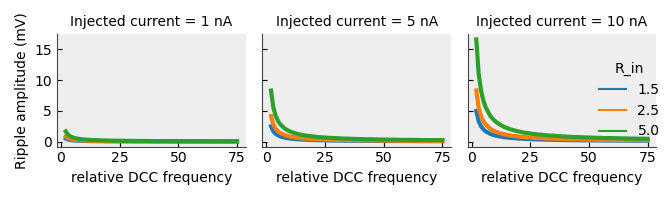

In [374]:
plt.style.use(['default','MM-model'])
g = sns.relplot(kind='line', data=result_ripples, x='relDCCfreq', y='ripple_amp_AU', hue='R_in', 
                col='I_com', palette='tab10', lw=3, height=2)
g.set_axis_labels(x_var='relative DCC frequency', y_var='Ripple amplitude (mV)')
g.set_titles(col_template="Injected current = {col_name} nA")
plt.tight_layout()

Figure-ripples

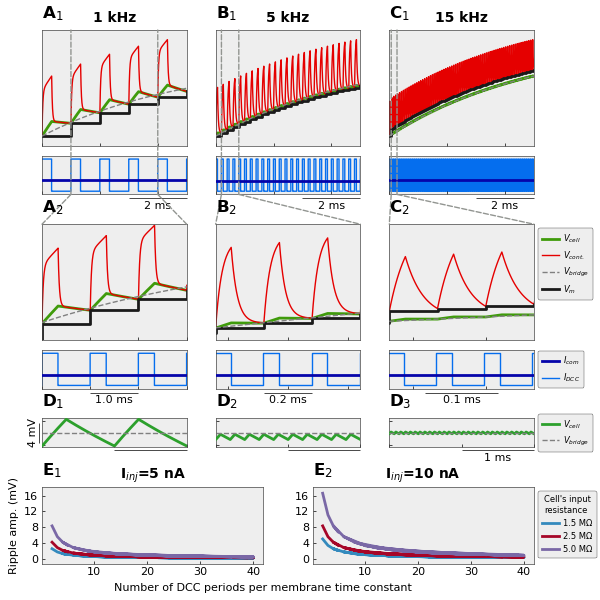

In [432]:
from matplotlib.patches import ConnectionPatch
N=3
cols = ['1 kHz', '5 kHz', '15 kHz']
freqs = [1e3, 5e3, 15e3]
ylims = [(0,6),(-0.25,4),(-0.5,3)]
dt0 = D / max(freqs)*Hz / points_per_DCC_period

ripples_Rin = 2.5
ripples_tauM = 3
ripples_Icom = 10


sns.set()
plt.style.use('default')
with plt.style.context(['default','MM-paper','MM-model',{'axes.ymargin':0.1, 'axes.xmargin':0.0}]):
    fig, axs = plt.subplots(9,3, figsize=(6,6), constrained_layout=False,
                           gridspec_kw=dict(height_ratios=[3,1,0.25,3,1,0.25,0.75,0.5,2]))

    
    for i,(col,tbar,xmin,freq,ylim) in enumerate(zip(cols,[1,0.2,0.1],[0,0,0],freqs,ylims)):
        xmax = xmin+5
        
        axV = axs[0,i]
        axI = axs[1,i]

        mask = (result_elect_cell.index>=xmin)&(result_elect_cell.index<xmax)
        df = result_elect_cell.loc[mask, col]
        
        for axV,axI in zip([axs[0,i],axs[3,i]], [axs[1,i], axs[4,i]]):
            axV.set_yticklabels([]); axV.set_xticklabels([])
            axI.set_yticklabels([]); axI.set_xticklabels([])
            axI.axhline(df['I'].mean(), c='xkcd:royal blue',    zorder=10, label='$I_{com}$', lw=2)
            axI.step(df.index, df['I'], c='xkcd:cerulean blue', zorder=1, label='$I_{DCC}$', lw=1)

            axV.plot(df.index, df['Vm'],          c='xkcd:grass green', lw=2, label='$V_{cell}$')
            axV.plot(df.index, df['Vm']+df['Ve'], c='xkcd:red',         lw=1, label='$V_{cont.}$')
            axV.plot(result_elect_cell.loc[mask].index, result_elect_cell.loc[mask, ('Bridge','Vm')], c='grey', ls='--', zorder=10, lw=1, label='$V_{bridge}$')
            # samples are taken at the end of each DCC cycle
            df_dcc = result_elect_cell.iloc[::int(1/freq / dt0)]
            df_dcc = df_dcc.loc[(df_dcc.index>=xmin)&(df_dcc.index<xmax), col]
            axV.step(df_dcc.index, df_dcc['Vm']+df_dcc['Ve'], where='post', lw=2, label='$V_{m}$', c='k')
            axV.set_yticks([])
            axI.set_yticks([])
        
        for ax in axs[3:5,i].flat:
            ax.set_xlim(xmin+1e3/freq, xmin+1e3*(N+1)/freq)
            ax.set_yticks([])
        axs[3,i].set_ylim(ylim)
        
        ax = axs[1,i]
        t = HSizeBar(ax.transData, 2, '2 ms', loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
        ax.add_artist(t)
        
        ax = axs[4,i]
        t = HSizeBar(ax.transData, tbar, f'{tbar:.1f} ms', loc='upper center',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(0.5, -0.1),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
        ax.add_artist(t)
        
        conn_kwargs=dict(color='xkcd:grey', lw=1, ls='--', zorder=100)
        transform = matplotlib.transforms.blended_transform_factory(axs[1,i].transData, axs[1,i].transAxes)
        for x0,x1 in enumerate([xmin+1e3/freq,xmin+1e3*(N+1)/freq]):
            con = ConnectionPatch(xyA=(x1,0), coordsA=transform, axesA=axs[1,i],
                            xyB=(x0,1), coordsB='axes fraction', axesB=axs[3,i],
                            **conn_kwargs)
            axs[3,i].add_artist(con)
        
            con = ConnectionPatch(xyA=(x1,0), coordsA=axs[1,i].get_xaxis_transform(), axesA=axs[1,i],
                                  xyB=(x1,1), coordsB=axs[0,i].get_xaxis_transform(), axesB=axs[0,i],
                                  **conn_kwargs)
            axs[1,i].add_artist(con)

    axs[3,-1].legend(loc='upper left', bbox_to_anchor=(1,1))
    axs[4,-1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    
    
    sim_dur = 50*ms
    t_ = np.linspace(0,sim_dur,int(sim_dur/dt))
    temp = result_ripples.loc[(result_ripples['I_com']==ripples_Icom)&
                              (result_ripples['R_in']==ripples_Rin)&
                              (result_ripples['tau_M']==ripples_tauM)]
    for i,(freq,ax) in enumerate(zip(freqs, axs[6,:])):
        y = temp.loc[temp['DCC_freq']==freq/1000,'data'].iloc[0]/mV
        ax.plot(t_,y, lw=2, c=f'C2', label='$V_{cell}$', zorder=9)
        ax.axhline(10*2.5, color='grey', ls='--', zorder=10, lw=1, label='$V_{bridge}$')
        ax.set_xlim(0.04,0.042)
        ax.set_ylim(22,28)
        #ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        #ax.set_title(f'{freq:d} kHz')
    ax = axs[6,0]
    v = VSizeBar(ax.transData, 4, '4 mV', loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
    ax.add_artist(v)
    for ax,l in zip(axs[6,:], ['','','1 ms']):
        t = HSizeBar(ax.transData, 1e-3, l, loc='upper right',
                         pad=0, borderpad=0, sep=2,
                         frameon=False,
                         bbox_to_anchor=(1, -0.1),
                         bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
        ax.add_artist(t)
    axs[6,-1].legend(loc='center left', bbox_to_anchor=(1,0.5))

    Is = [5,10]
    Rs = [1.5,2.5,5]

    for ax,I in zip(axs[8,0:-1], Is):
        ax.margins(x=0.05)
        for R in Rs:
            df = result_ripples.loc[(result_ripples['I_com']==I)&
                                    (result_ripples['R_in']==R)&
                                    (result_ripples['relDCCfreq']<=40)]
            ax.plot(df['relDCCfreq'],df['ripple_amp_AU'], lw=2, label=f'{R:.1f} MΩ')
        ax.set_title(f'I$_{{inj}}$={I:.0f} nA')
    for ax in axs[8,0:-1]:
        ax.set_ylim(axs[8,1].get_ylim())
        ax.set_xticks([10,20,30,40])
        ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(symbol='', decimals=0))
        ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(min_n_ticks=4, nbins=5))
    axs[8,0].set_ylabel('Ripple amp. (mV)')
    l = axs[8,0].set_xlabel('Number of DCC periods per membrane time constant', ha='center', x=1)
    axs[8,1].legend(loc='upper left', bbox_to_anchor=(1,1), title='Cell\'s input\nresistance')

    
    
    with plt.style.context(['default','MM-paper']):
        for ax,l,col in zip(axs[0,:],['A$_1$','B$_1$','C$_1$'],cols):
            ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                          xytext=(0,5), textcoords='offset points',
                          ha='left', va='bottom', fontsize=12, fontweight='bold')
            ax.set_title(col)
        for ax,l in zip(axs[3,:],['A$_2$','B$_2$','C$_2$']):
            ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                          xytext=(0,5), textcoords='offset points',
                          ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)
        for ax,l in zip(axs[6,:],['D$_1$','D$_2$','D$_3$']):
            ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                          xytext=(0,5), textcoords='offset points',
                          ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)
        for ax,l in zip(axs[8,:2],['E$_1$','E$_2$']):
            ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                          xytext=(0,5), textcoords='offset points',
                          ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)

    for i in range(3):
        axs[2,i].remove()
        axs[5,i].remove()
        axs[7,i].remove()
        
        
        
        
#fig.set_facecolor('grey')
fig.subplots_adjust(left=0.07, right=0.89, top=0.95, bottom=0.06)

# remove lower right Axes and expand bottom plots
b0 = axs[8,0].get_position()
b1 = axs[8,1].get_position()
b2 = axs[8,2].get_position()
axs[8,-1].remove()
w = (b2.x1-b0.x0)/2 * (1-plt.rcParams['figure.subplot.wspace']/2)
axs[8,0].set_position([b0.x0, b0.y0, w, b0.height])
axs[8,1].set_position([b2.x1-w, b1.y0, w, b1.height])


fig.savefig('../Figure-numerical-sim.png', dpi=300)

### Staircase effect

For the firing model, we use the same equations as in (Meunier and Borejsza, 2005) and (Manuel et al., 2006):

$$
\begin{align}
C*\frac{dV_m}{dt} & = G_{in}*(V_r-V_m)+I_{AHP}+I_{inj}+\sigma\xi \\
I_{AHP} & = \bar{g}_{AHP} * z * (E_k-V_m) \\
\frac{dz}{dt} & = \frac{-z}{\tau_{AHP}} \\
\end{align}
$$
    
    

for simplicity, the dynamic of the AHP during the spike is not modeled, and instead, the parameter $z$ is incremented instantenously at each spike according to:
$$ z_{after} = (1 - \alpha) * z_{before} + \alpha $$

In [434]:
eqs = '''
dv/dt = (G_in*(V_r-v)+I_ahp+I)/(G_in*tau_M) + sigma*xi: volt
I = I_com(t) : amp
I_ahp = G_ahp * z * (E_k-v) : amp
dz/dt = -z/tau_ahp : 1
'''
z_eq = 'z = (1-alpha)*z+alpha'

In [435]:
# Neuron parameters
tau_M = 2 * ms
R_in = 1.5 * Mohm
G_in = 1/R_in
V_r = 0 * mV
V_thresh = 10 * mV
refract = 2 * ms
sigma = 0.05 * mV * ms ** -0.5
G_ahp = 2 * uS
E_k = -5 * mV
tau_ahp = 10 * ms
alpha = 0.25
D = 1 / 3
points_per_DCC_period = 10
ramp_rate = 1 * nA / second
ramp_max = 15 * nA

DCC_freq = [0, 1, 3, 8] * kHz

In [141]:
traces_staircase = pd.DataFrame()
FI_curves_staircase = pd.DataFrame()
for DCC_freq in tqdm(DCC_freqs):
    br.start_scope()
    np.random.seed(14235976)  # for reproductibility
    if DCC_freq == 0:
        dt = 100 * us
    else:
        dt = D / DCC_freq / points_per_DCC_period
    
    br.defaultclock.dt = dt

    I_ramp = create_ramp(dt, ramp_rate, ramp_max, downward=False)
    sim_dur = ramp_max/ramp_rate

    G = br.NeuronGroup(1, eqs, method='euler', threshold='v>V_thresh', refractory=refract)
    S = br.Synapses(G, on_pre=z_eq)
    S.connect()
    M = br.StateMonitor(G, variables=['v', 'z', 'I'], record=[0])
    SM = br.SpikeMonitor(G)

    I_bridge = br.TimedArray(I_ramp * amp, dt=dt)
    if DCC_freq == 0:  # Bridge mode
        I_com = I_bridge
    else:
        I_dcc = chop_current(I_ramp, dt, freq=DCC_freq, duty_cycle=D)
        I_com = br.TimedArray(I_dcc * amp, dt=dt)
    
    with brian_tqdm(total=1., leave=False) as pbar:
        br.run(sim_dur, report=pbar.update_to)
    
    t = pd.DataFrame({'t':M.t/second,'v':M.v[0]/mV, 'z':M.z[0], 'I':M.I[0]/nA}).assign(tau_M=tau_M,G_in=G_in,sigma=sigma,G_ahp=G_ahp,tau_ahp=tau_ahp,alpha=alpha,DCC_freq=DCC_freq,ramp_max=ramp_max)
    f = pd.DataFrame({'i':ramp_rate*SM.t/nA,'t':SM.t/second}).assign(tau_M=tau_M,G_in=G_in,sigma=sigma,G_ahp=G_ahp,tau_ahp=tau_ahp,alpha=alpha,DCC_freq=DCC_freq,ramp_max=ramp_max)
    f['freq'] = 1./f['t'].diff()
    traces_staircase = pd.concat([traces_staircase, t], axis=0)
    FI_curves_staircase = pd.concat([FI_curves_staircase, f], axis=0)

In [326]:
for f in [1,3,8]*kHz:
    print(D / f / points_per_DCC_period)

33.33333333 us
11.11111111 us
4.16666667 us


Text(0.5, 0, 'ISI normalized by DCC period')

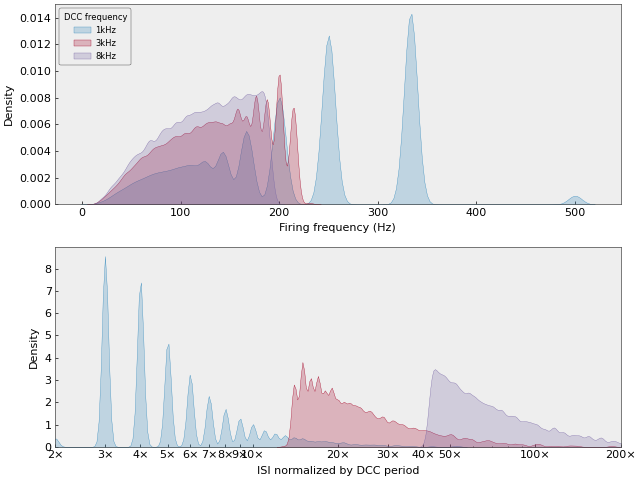

In [276]:
xticks = np.concatenate([np.arange(2,11),[20,30,40,50],[100,200]])
#xticklabels = np.full(shape=xticks.shape, fill_value=None)
#xticklabels[:8] = [f'{a}×' for a in [3,4,5,6,7,8,9,10]]
#xticklabels[17] = '20×'
#xticklabels[20] = '50×'

plt.style.use(['default','MM-paper','MM-model'])
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout=True)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

for f,o in FI_curves_staircase.loc[FI_curves_staircase['DCC_freq']>0].groupby('DCC_freq'):
    freq = o['freq']
    sns.kdeplot(x=freq, fill=True, bw_adjust=0.3, label=f'{f/1000:.0f}kHz', ax=ax1)
    sns.kdeplot(x=(1/freq)/(1/f), fill=True, bw_adjust=0.2, label=f'{f/1000:.0f}kHz', ax=ax2, log_scale=True)

ax2.set_xlim(4,100)    

ax2.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=100, symbol='×'))
ax2.set_xticks(xticks)
#ax2.set_xticklabels(xticklabels, rotation=90)
#ax2.invert_xaxis()

ax1.legend(title='DCC frequency', loc='upper left')
ax1.set_xlabel('Firing frequency (Hz)')
ax2.set_xlabel('ISI normalized by DCC period')


14.103766666666665 14.109099999999998
14.109099999999998 14.114433333333332
14.11 14.109099999999998
14.1162 14.114433333333332


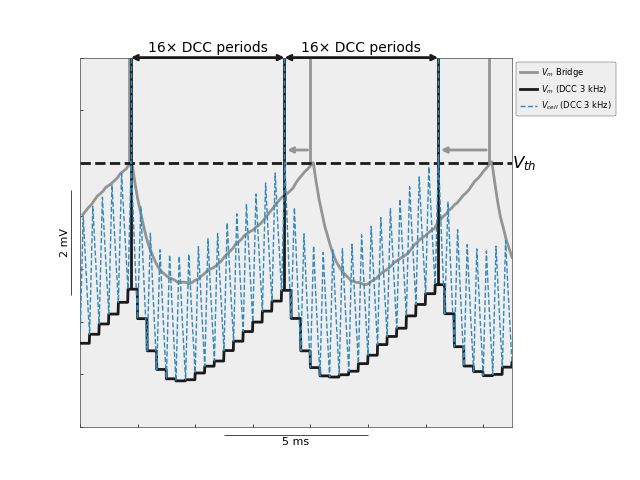

In [282]:
xmin, xmax = 14.102,14.117
ymin, ymax = 5,12


plt.style.use(['default','MM-paper','MM-model'])
fig, ax = plt.subplots()
ax.set_axisbelow(True)

# Bridge trace
DCC_freq=0
o = traces_staircase.loc[(traces_staircase['DCC_freq']==DCC_freq)&(traces_staircase['t'].between(xmin,xmax))]
p = FI_curves_staircase.loc[(FI_curves_staircase['DCC_freq']==DCC_freq)&FI_curves_staircase['t'].between(xmin,xmax)]
ax.plot(o['t'], o['v'], c='xkcd:grey', lw=2, ls='-', label='$V_m$ Bridge')
ax.eventplot(p['t'], lineoffsets=11, linelengths=2, colors='xkcd:grey', linewidths=2, linestyles='-')
t_spikes_bridge = p['t']

# DCC trace
DCC_freq=3000
dt = D / DCC_freq / points_per_DCC_period
o = traces_staircase.loc[(traces_staircase['DCC_freq']==DCC_freq)&(traces_staircase['t'].between(xmin,xmax))]
p = FI_curves_staircase.loc[(FI_curves_staircase['DCC_freq']==DCC_freq)&FI_curves_staircase['t'].between(xmin,xmax)]
a = (traces_staircase.loc[traces_staircase['DCC_freq']==DCC_freq]
     .iloc[::int(points_per_DCC_period/D)]
)
q = a.set_index('t').reindex(traces_staircase.loc[traces_staircase['DCC_freq']==DCC_freq].set_index('t').index).reset_index().ffill()
#q = q.loc[q['t'].between(xmin,xmax)]
v_dcc_spikes = q.set_index('t').loc[p['t'],'v'].values
t_spikes_dcc = p['t']

ax.plot(q['t'], 
        q['v'],
        color='k', lw=2, ls='-',
        label=f'$V_{{m}}$ (DCC {dcc/1000:.0f} kHz)', zorder=10)
ax.vlines(p['t'], ymin=v_dcc_spikes, ymax=12, color='k', lw=2, ls='-', zorder=10)

ax.plot(o['t'], o['v'], c='C0', lw=1, ls='--', label=f'$V_{{cell}}$ (DCC {dcc/1000:.0f} kHz)', zorder=11)
ax.eventplot(p['t'], lineoffsets=11, linelengths=2, colors='C0', linewidths=1, linestyles='--', zorder=11)

ax.axhline(10, ls='--', lw=2, color='k')
ax.annotate("$V_{th}$", xy=(1,10), xycoords=('axes fraction','data'), ha='left', va='center', fontsize=12)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

for t,u in zip(t_spikes_dcc[:-1],t_spikes_dcc[1:]):
    print(t,u)
    ax.annotate('', xy=(t,1), xytext=(u,1), xycoords=('data','axes fraction'),
               arrowprops=dict(arrowstyle='<->', lw=2, color='k', shrinkA=0, shrinkB=0))
    ax.annotate(f'{(u-t)*(dcc):.0f}× DCC periods', 
                xy=(t+(u-t)/2,1), xycoords=('data','axes fraction'),
                xytext=(0,2), textcoords='offset points',
                ha='center', va='bottom', fontsize=10)

for t,u in zip(t_spikes_bridge[1:], t_spikes_dcc[1:]):
    print(t,u)
    ax.annotate('', xy=(t,0.75), xycoords=('data','axes fraction'), xytext=(u,0.75), 
                arrowprops=dict(arrowstyle='<-', lw=2, color='xkcd:grey'))
    
ax.set_yticklabels([])
ax.set_xticklabels([])

v = VSizeBar(ax.transData, 2, '2 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(v)

t = HSizeBar(ax.transData, 5e-3, '5 ms', loc='upper center',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(0.5, -0.02),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(t)

ax.legend(loc='upper left', bbox_to_anchor=(1,1))
fig.subplots_adjust(right=0.8)

#### Figure-step-pattern

In [1233]:
plt.style.reload_library()

14.103766666666665 14.109099999999998
14.109099999999998 14.114433333333332
14.11 14.109099999999998
14.1162 14.114433333333332


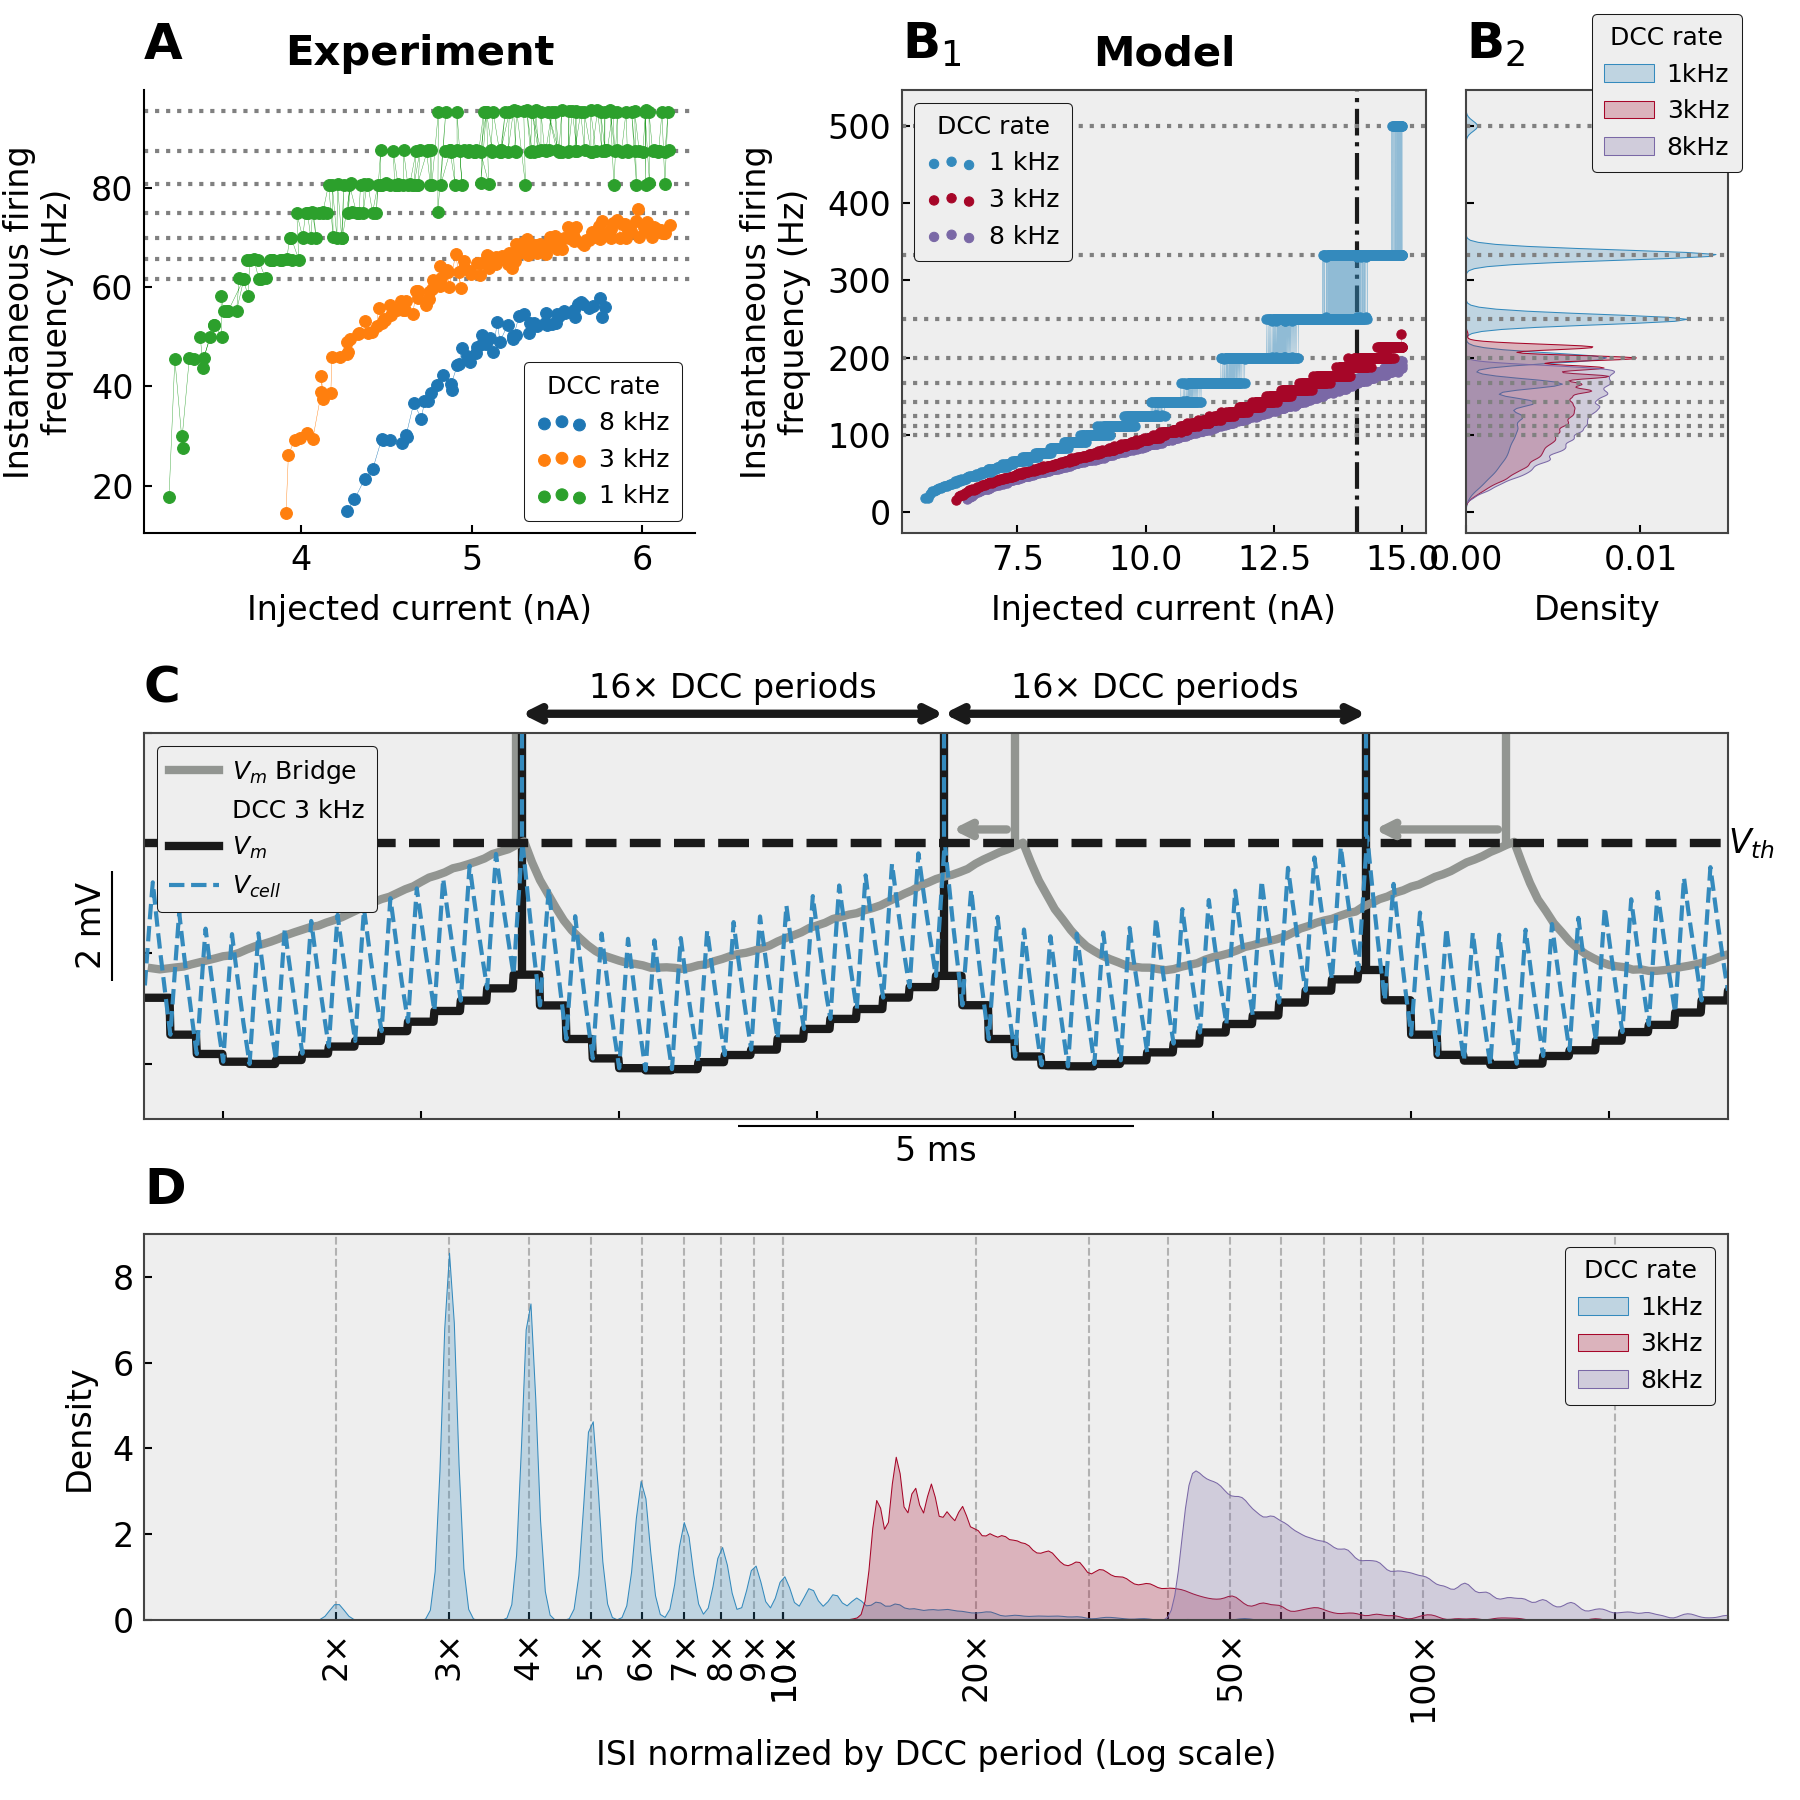

In [323]:
xmin, xmax = 14.099,14.119


plt.style.use(['default','MM-paper',{'axes.xmargin':0.05, 'axes.ymargin':0.05}])


fig = plt.figure(constrained_layout=False, figsize=(6,6), dpi=300)
gs = matplotlib.gridspec.GridSpec(2,2, figure=fig, 
                                  width_ratios=[1,1.5],
                                  height_ratios=[1,2],
                                  wspace=0.3, hspace=0.3)
gs0 = matplotlib.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,1],
                                                  width_ratios=[1,0.5], wspace=0.1)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,:],
                                                  hspace=0.3)

ax1 = fig.add_subplot(gs[0,0])
ax = ax1
ax.set_title('Experiment')
for file, freq in zip(['20200701_Cell4090_006_IFCurve_DCC8kHz.txt',
                       '20200701_Cell4090_006_IFCurve_DCC3kHz.txt',
                       '20200701_Cell4090_006_IFCurve_DCC1kHz.txt'],
                      ['8 kHz', '3 kHz', '1 kHz']):
    df = pd.read_csv(file, sep='\t', usecols=[2,3], header=0, names=['Im','Freq'])
    ax.scatter(df['Im'],df['Freq'],s=8,label=freq, zorder=10)
    ax.plot(df['Im'],df['Freq'],'-', lw=0.1, zorder=9)


ax.set_xlabel('Injected current (nA)')
ax.set_ylabel('Instantaneous firing\nfrequency (Hz)')
ax.legend(loc='lower right', scatterpoints=3, title='DCC rate')
DCCfreq = 1050
for d in range(11,18,1):
    ax.axhline(DCCfreq/d, ls=':', c='grey', lw=1, zorder=2)
#    ax.annotate(f'1/{d}', xy=(1,DCCfreq/d), xycoords=('axes fraction', 'data'),
#                ha='left', va='center', fontsize=6)


plt.style.use(['default','MM-paper','MM-model'])
ax2 = fig.add_subplot(gs0[0,0])
ax3 = fig.add_subplot(gs0[0,1], sharey=ax2)
zs = [5.3,5.2,5.1]
for z,(f,o) in zip(zs,FI_curves_staircase.loc[FI_curves_staircase['DCC_freq']>0].groupby('DCC_freq')):
    ax2.scatter(o['i'],o['freq'], 
               s=5, label=f'{f/1000:.0f} kHz', zorder=z)
    ax2.plot(o['i'],o['freq'],'-', lw=0.1, zorder=z, alpha=0.5)
    
    sns.kdeplot(y=o['freq'], fill=True, bw_adjust=0.3, label=f'{f/1000:.0f}kHz', ax=ax3)
ax2.set_xlabel('Injected current (nA)')
ax2.set_ylabel('Instantaneous firing\nfrequency (Hz)')
ax2.legend(scatterpoints=3, title='DCC rate')
ax2.set_title('Model')
ax2.axvline(np.mean([xmin,xmax]), ls='-.', color='k', lw=1)

plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.yaxis.get_label(), visible=False)
ax3.legend(loc='upper right', bbox_to_anchor=(1.1,1.2), title='DCC rate')


for ax in [ax2, ax3]:
    DCCfreq = 1000
    for d in range(2,11,1):
        ax.axhline(DCCfreq/d, ls=':', c='grey', lw=1, zorder=2)
    #    ax.annotate(f'1/{d}', xy=(1,DCCfreq/d), xycoords=('axes fraction', 'data'),
    #                ha='left', va='center', fontsize=6)



ax4 = fig.add_subplot(gs1[0])
ax = ax4
ax.set_axisbelow(True)
ymin, ymax = 5,12

# Bridge trace
DCC_freq=0
o = traces_staircase.loc[(traces_staircase['DCC_freq']==DCC_freq)&(traces_staircase['t'].between(xmin,xmax))]
p = FI_curves_staircase.loc[(FI_curves_staircase['DCC_freq']==DCC_freq)&FI_curves_staircase['t'].between(xmin,xmax)]
ax.plot(o['t'], o['v'], c='xkcd:grey', lw=2, ls='-', label='$V_m$ Bridge')
ax.eventplot(p['t'], lineoffsets=11, linelengths=2, colors='xkcd:grey', linewidths=2, linestyles='-')
t_spikes_bridge = p['t']

# DCC trace
DCC_freq=3000
dt = D / DCC_freq / points_per_DCC_period
o = traces_staircase.loc[(traces_staircase['DCC_freq']==DCC_freq)&(traces_staircase['t'].between(xmin,xmax))]
p = FI_curves_staircase.loc[(FI_curves_staircase['DCC_freq']==DCC_freq)&FI_curves_staircase['t'].between(xmin,xmax)]
a = (traces_staircase.loc[traces_staircase['DCC_freq']==DCC_freq]
     .iloc[::int(points_per_DCC_period/D)]
)
q = a.set_index('t').reindex(traces_staircase.loc[traces_staircase['DCC_freq']==DCC_freq].set_index('t').index).reset_index().ffill()
#q = q.loc[q['t'].between(xmin,xmax)]
v_dcc_spikes = q.set_index('t').loc[p['t'],'v'].values
t_spikes_dcc = p['t']

ax.plot(q['t'], 
        q['v'],
        color='k', lw=2, ls='-',
        label=f'$V_{{m}}$')
ax.vlines(p['t'], ymin=v_dcc_spikes, ymax=12, color='k', lw=2, ls='-')

ax.plot(o['t'], o['v'], c='C0', lw=1, ls='--', label=f'$V_{{cell}}$')
ax.eventplot(p['t'], lineoffsets=11, linelengths=2, colors='C0', linewidths=1, linestyles='--')

ax.axhline(10, ls='--', lw=2, color='k')
ax.annotate("$V_{th}$", xy=(1,10), xycoords=('axes fraction','data'), 
            ha='left', va='center', fontsize=8)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

pos = 1.05
for t,u in zip(t_spikes_dcc[:-1],t_spikes_dcc[1:]):
    print(t,u)
    ax.annotate('', xy=(t,pos), xytext=(u,pos), xycoords=('data','axes fraction'),
               arrowprops=dict(arrowstyle='<->', lw=2, color='k', shrinkA=0, shrinkB=0))
    ax.annotate(f'{(u-t)*(dcc):.0f}× DCC periods', 
                xy=(t+(u-t)/2,pos), xycoords=('data','axes fraction'),
                xytext=(0,2), textcoords='offset points',
                ha='center', va='bottom', fontsize=8)

for t,u in zip(t_spikes_bridge[1:], t_spikes_dcc[1:]):
    print(t,u)
    ax.annotate('', xy=(t,0.75), xycoords=('data','axes fraction'), xytext=(u,0.75), 
                arrowprops=dict(arrowstyle='<-', lw=2, color='xkcd:grey'))
    
ax.set_yticklabels([])
ax.set_xticklabels([])

v = VSizeBar(ax.transData, 2, '2 mV', loc='center right',
            pad=0, borderpad=0, sep=1,
            frameon=False,
            bbox_to_anchor=(-0.02, 0.5),
            bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(v)

t = HSizeBar(ax.transData, 5e-3, '5 ms', loc='upper center',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(0.5, -0.02),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=8))
ax.add_artist(t)

h,l = ax.get_legend_handles_labels()
proxy, = ax.plot([],[],'-',lw=0)
h.insert(1, proxy)
l.insert(1, f'DCC {DCC_freq/1000:.0f} kHz')
ax.legend(h,l, loc='upper left', bbox_to_anchor=(0,1))



ax5 = fig.add_subplot(gs1[1])
ax = ax5
ax.set_axisbelow(True)

for f,o in FI_curves_staircase.loc[FI_curves_staircase['DCC_freq']>0].groupby('DCC_freq'):
    sns.kdeplot(x=f/o['freq'], fill=True, bw_adjust=0.2, log_scale=True, 
                label=f'{f/1000:.0f}kHz', ax=ax)

        
xticks = np.concatenate([np.arange(2,11),np.arange(10,100,10),[100,200]])
xticklabels_pos=[2,3,4,5,6,7,8,9,10,20,50,100]
xticklabels = [f'{a}×' if a in xticklabels_pos else '' for a in xticks]
ax.set_xlim(1,300)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=90)

ax.set_xlabel('ISI normalized by DCC period (Log scale)')
ax.grid(True, axis='x', which='major', lw=0.5, ls='--')
ax.legend(loc='upper right', title='DCC rate')


for ax,l in zip(fig.axes,
                ['A','B$_1$','B$_2$','C','D']):
    ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                  xytext=(0,5), textcoords='offset points',
                  ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)

#fig.set_facecolor('grey')
fig.subplots_adjust(left=0.08, right=0.96, top=0.95, bottom=0.1)
fig.savefig('../Figure-step-pattern.png', dpi=300)

### Secondary range

In [437]:
# Neuron parameters
R_in = 2.5 * Mohm
G_in = 1/R_in
DCC_freqs = [0, 3] * kHz

In [345]:
FI_curves_secrange = pd.DataFrame()
for DCC_freq in tqdm(DCC_freqs):
    br.start_scope()
    np.random.seed(14235976)  # for reproductibility
    if DCC_freq == 0:
        dt = 100 * us
    else:
        dt = D / DCC_freq / points_per_DCC_period
    
    br.defaultclock.dt = dt

    I_ramp = create_ramp(dt, ramp_rate, ramp_max, downward=False)
    sim_dur = ramp_max/ramp_rate

    G = br.NeuronGroup(1, eqs, method='euler', threshold='v>V_thresh', refractory=refract)
    S = br.Synapses(G, on_pre=z_eq)
    S.connect()
    #M = br.StateMonitor(G, variables=['v', 'z', 'I'], record=[0])
    SM = br.SpikeMonitor(G)

    I_bridge = br.TimedArray(I_ramp * amp, dt=dt)
    if DCC_freq == 0:  # Bridge mode
        I_com = I_bridge
    else:
        I_dcc = chop_current(I_ramp, dt, freq=DCC_freq, duty_cycle=D)
        I_com = br.TimedArray(I_dcc * amp, dt=dt)
    
    with brian_tqdm(total=1., leave=False) as pbar:
        br.run(sim_dur, report=pbar.update_to)
    
    #t = pd.DataFrame({'t':M.t/second,'v':M.v[0]/mV, 'z':M.z[0], 'I':M.I[0]/nA}).assign(tau_M=tau_M,G_in=G_in,sigma=sigma,G_ahp=G_ahp,tau_ahp=tau_ahp,alpha=alpha,DCC_freq=DCC_freq,ramp_max=ramp_max)
    f = pd.DataFrame({'i':ramp_rate*SM.t/nA,'t':SM.t/second}).assign(tau_M=tau_M,G_in=G_in,sigma=sigma,G_ahp=G_ahp,tau_ahp=tau_ahp,alpha=alpha,DCC_freq=DCC_freq,ramp_max=ramp_max)
    f['freq'] = 1./f['t'].diff()
    
    FI_curves_secrange = pd.concat([FI_curves_secrange, f], axis=0)

#### Figure-secondary-range

8kHz: 6.788865556586735 Hz/nA
3kHz: 10.508030417546346 Hz/nA
3kHz: 20.651614766895335 Hz/nA


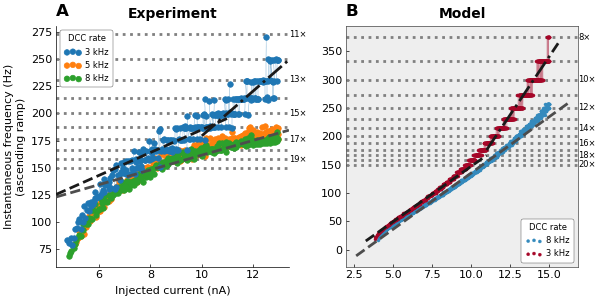

In [438]:
fig = plt.figure(figsize=(6,3), constrained_layout=True)
gs00 = matplotlib.gridspec.GridSpec(1, 2, figure=fig)
plt.style.use(['default','MM-paper',{'axes.xmargin':0.05, 'axes.ymargin':0.05}])
ax1 = fig.add_subplot(gs00[0])
ax1.set_title('Experiment')

with plt.style.context(['MM-paper','MM-model']):
    ax2 = fig.add_subplot(gs00[1])
ax2.set_title('Model')


ax = ax1
for file,freq,z in zip(
                                    ['20200707_Cell4099_002_IFCurve_DCC3kHz.txt',
                                     '20200707_Cell4099_002_IFCurve_DCC5kHz.txt',
                                     '20200707_Cell4099_002_IFCurve_DCC8kHz_5nAs.txt'],
                                   ['3 kHz','5 kHz','8 kHz'],
                                    [22,20,21]):
    df = pd.read_csv(file, sep='\t', header=0)
    df = df.loc[df.iloc[:,2]<13]
    ax.scatter(df.iloc[:,2], df.iloc[:,3], marker='o', s=4**2, lw=0.5, label=freq, zorder=z)
    ax.plot(df.iloc[:,2], df.iloc[:,3], '-', lw=0.1, zorder=z-1)
ax.set_xlabel('Injected current (nA)')
ax.set_ylabel('Instantaneous frequency (Hz)\n(ascending ramp)')
ax.legend(loc='upper left', scatterpoints=3,
          title='DCC rate')
fig.canvas.draw()
ax.autoscale(False)

df = pd.read_csv('20200707_Cell4099_002_IFCurve_DCC8kHz_5nAs.txt', sep='\t', header=0)
df = df.loc[(df.iloc[:,2]>7)&(df.iloc[:,2]<13)]
s,i,r,p,e = st.linregress(df.iloc[:,[2,3]].values.T)
print('8kHz:', s, 'Hz/nA')
x = np.array(ax.get_xlim())
y = s*x+i
ax.plot(x,y, '--', c=[.3]*3, lw=2, zorder=30)

df = pd.read_csv('20200707_Cell4099_002_IFCurve_DCC3kHz.txt', sep='\t', header=0)
df = df.loc[(df.iloc[:,2]>8)&(df.iloc[:,2]<9)]
s,i,r,p,e = st.linregress(df.iloc[:,[2,3]].values.T)
x = np.array([ax.get_xlim()[0],11])
y = s*x+i
print('3kHz:', s, 'Hz/nA')
ax.plot(x,y, '--', c='k', lw=2, zorder=30)

df = pd.read_csv('20200707_Cell4099_002_IFCurve_DCC3kHz.txt', sep='\t', header=0)
df = df.loc[(df.iloc[:,2]>11)&(df.iloc[:,2]<13)]
s,i,r,p,e = st.linregress(df.iloc[:,[2,3]].values.T)
print('3kHz:', s, 'Hz/nA')
x = np.array([10,ax.get_xlim()[1]])
y = s*x+i
ax.plot(x,y, '-.', c='k', lw=2, zorder=30)

r = range(11,21)
for d in r:
    ax.axhline(3000/d, ls=':', lw=2, c='grey', zorder=2)
for d in r[::2]:
    ax.annotate(f'{d}×', xy=(1,3000/d), xycoords=('axes fraction', 'data'),
                 ha='left', va='center', fontsize=6)


    
for (_,o),freq in zip(FI_curves_secrange.groupby('DCC_freq'),
                      ['8 kHz','3 kHz']):
    ax2.scatter(o['i'],o['freq'], 
               s=5, label=freq, zorder=z)
    ax2.plot(o['i'],o['freq'],'-', lw=0.1, zorder=z, alpha=0.5)
ax2.legend(scatterpoints=3,
          title='DCC rate')

o = FI_curves_secrange.loc[(FI_curves_secrange['DCC_freq']==3000)&
                           (FI_curves_secrange['i'].between(5,8))]
s,i,r,p,e = st.linregress(o['i'],o['freq'])
x = np.array([ax2.get_xlim()[0],11])
y = s*x+i
ax2.plot(x,y, '--', c='k', lw=2, zorder=30)

o = FI_curves_secrange.loc[(FI_curves_secrange['DCC_freq']==3000)&
                           (FI_curves_secrange['i'].between(11,15))]
s,i,r,p,e = st.linregress(o['i'],o['freq'])
x = np.array([11,ax2.get_xlim()[1]])
y = s*x+i
ax2.plot(x,y, '-.', c='k', lw=2, zorder=30)

o = FI_curves_secrange.loc[(FI_curves_secrange['DCC_freq']==0)&
                           (FI_curves_secrange['i'].between(6,13))]
s,i,r,p,e = st.linregress(o['i'],o['freq'])
x = np.array(ax2.get_xlim())
y = s*x+i
ax2.plot(x,y, '--', c=[.3]*3, lw=2, zorder=30)

r = range(8,21)
for d in r:
    ax2.axhline(3000/d, ls=':', lw=2, c='grey', zorder=2)
for d in r[::2]:
    ax2.annotate(f'{d}×', xy=(1,3000/d), xycoords=('axes fraction', 'data'),
                 ha='left', va='center', fontsize=6)

for ax,l in zip(fig.axes,
                ['A','B']):
    ax.annotate(l,xy=(0,1),xycoords='axes fraction',
                  xytext=(0,5), textcoords='offset points',
                  ha='left', va='bottom', fontsize=12, fontweight='bold', zorder=1000)

fig.savefig('../Figure-secondary-range.png', dpi=300)

# Mice

Number of mice

In [450]:
summary['expDate'].unique().size

7

In [464]:
summary.groupby(['expDate']).first().groupby('mouseType').size()

mouseType
B6SJL      4
C57BL/6    3
dtype: int64

In [465]:
summary.groupby('expDate').first().describe()[['mouseAge','mouseWeight']]

,mouseAge,mouseWeight
count,7.000000,7.000000
mean,104.571429,27.857143
std,66.635469,2.340126
min,49.000000,25.000000
25%,51.000000,26.000000
50%,54.000000,28.000000
75%,172.500000,29.500000
max,182.000000,31.000000


In [467]:
summary.groupby('cell').first().describe()[['electrodeR']]

,electrodeR
count,13.000000
mean,23.153846
std,5.927987
min,16.000000
25%,17.000000
50%,25.000000
75%,28.000000
max,33.000000
